In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import log_softmax, softmax
from shrek import SHREK
np.random.seed(1)

## Generate some example data

In [2]:
n_channel, n_Tz = (3, 50)
n = 5000 # number of replication
K = 5 # how may categories

# true correlation matrix
Omega = np.array(
    [[1, -0.3, 0], 
     [-0.3, 1, 0.3], 
     [0, 0.3, 1]]
)
L = np.linalg.cholesky(Omega)
betaMat = 0.02 * L @ np.cumsum(np.random.normal(size=(n_channel, n_Tz)), axis = 1)

alpha = 0.01
betaMat[np.logical_and(betaMat < alpha, betaMat > -alpha)] = 0
betaMat[betaMat > alpha] -= alpha
betaMat[betaMat < -alpha] += alpha

X_train = np.random.normal(size=(n, K, n_channel, n_Tz))
p_train = softmax(np.tensordot(X_train, betaMat, [[2, 3], [0, 1]]), axis = 1)
y_train = np.array([np.random.multinomial(1, p) for p in p_train])

X_test = np.random.normal(size=(n, K, n_channel, n_Tz))
p_test = softmax(np.tensordot(X_test, betaMat, [[2, 3], [0, 1]]), axis = 1)
y_test = np.array([np.random.multinomial(1, p) for p in p_test])

## Usage of the code

In [3]:
model = SHREK(alpha)
model.fit(X_train, y_train)

## Result

First, we can test the model's prediction accuracy on the test data

In [4]:
phat_test = model.predict_logprob(X_test)
accuracy = np.mean(np.argmax(phat_test, axis=1) == np.argmax(y_test, axis=1))
'Testing accuracy: {:.2%}'.format(accuracy)

'Testing accuracy: 42.14%'

Second, we can see the weights are recovered very well

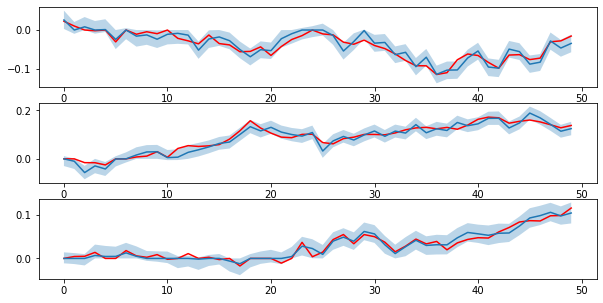

In [5]:
fig, axes = plt.subplots(n_channel, 1, figsize=(10, 5))
cis = np.quantile(model.betaMats, [0.05, 0.95], axis=0)
for ax, beta in zip(axes, betaMat):
    ax.plot(beta, color='red')
for ax, beta, lb, ub in zip(axes, model.betaMat, cis[0], cis[1]):
    ax.plot(beta)
    ax.fill_between(np.arange(n_Tz), lb, ub, alpha=0.3)

Third, we look at estimated correlation matrix, and 95% CIs.

In [6]:
# The true correlation matrix
np.round(Omega, 2)

array([[ 1. , -0.3,  0. ],
       [-0.3,  1. ,  0.3],
       [ 0. ,  0.3,  1. ]])

In [7]:
# The posterior median
corrs = np.round(model.corr, 2)
corrs[1]

array([[ 1.  , -0.43, -0.11],
       [-0.43,  1.  ,  0.52],
       [-0.11,  0.52,  1.  ]])

In [8]:
# The 95% CIs
corrs[0], corrs[2]

(array([[ 1.  , -0.51, -0.23],
        [-0.51,  1.  ,  0.4 ],
        [-0.23,  0.4 ,  1.  ]]),
 array([[ 1.  , -0.34,  0.01],
        [-0.34,  1.  ,  0.61],
        [ 0.01,  0.61,  1.  ]]))